### BERT Classification

In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

In [3]:
def load_sarcasm_data(file_path):
    df = pd.read_json(file_path,lines=True)
    return df

In [4]:
file_path = "Sarcasm_Headlines_Dataset.json"
df = load_sarcasm_data(file_path)
df.dropna(inplace = True)
texts = df["headline"].tolist()
labels = df["is_sarcastic"].tolist()
df.head()


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [6]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        # load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [7]:
from tqdm.auto import tqdm

def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    with tqdm(total=len(data_loader), desc="Training") as pbar:
        for batch in data_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            pbar.update(1)  # Update progress bar

In [8]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions, output_dict=True)

In [9]:
def predict_sarcasm(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "is_sarcasm" if preds.item() == 1 else "not_sarcasm"


In [10]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 1
learning_rate = 2e-5

In [11]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [12]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [14]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
print(f"Index of the missing element: {9971}")
print(f"Length of the dataset: {len(train_dataloader.dataset)}")

Index of the missing element: 9971
Length of the dataset: 21367


In [16]:
# Check the length of the dataset
print("Length of train_dataset:", len(train_dataset))

# Print out a batch from the DataLoader
for batch in train_dataloader:
    print(batch)
    break  # Print only the first batch for inspection

Length of train_dataset: 21367
{'input_ids': tensor([[  101,  3104,  3661,  ...,     0,     0,     0],
        [  101,  2448,  1010,  ...,     0,     0,     0],
        [  101,  2450,  2038,  ...,     0,     0,     0],
        ...,
        [  101, 15967,  2792,  ...,     0,     0,     0],
        [  101,  2065, 10474,  ...,     0,     0,     0],
        [  101,  1996,  2088,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'label': tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0])}


In [17]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/1


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation Accuracy: 0.9285
{'0': {'precision': 0.9257328990228013, 'recall': 0.9485981308411215, 'f1-score': 0.9370260468183317, 'support': 2996}, '1': {'precision': 0.9322183098591549, 'recall': 0.9028132992327366, 'f1-score': 0.9172802078822, 'support': 2346}, 'accuracy': 0.9284912017970798, 'macro avg': {'precision': 0.928975604440978, 'recall': 0.925705715036929, 'f1-score': 0.9271531273502658, 'support': 5342}, 'weighted avg': {'precision': 0.928581040883918, 'recall': 0.9284912017970798, 'f1-score': 0.9283544372817976, 'support': 5342}}


In [18]:
val_dataloader.dataset.texts[:2],val_dataloader.dataset.labels[:2]


(['isis recruiter excited to be talking to popular high schooler for once',
  'jimmy fallon could barely keep it together during this cardi b interview'],
 [1, 0])

In [19]:
# Test sentiment prediction
test_text = "isis recruiter excited to be talking to popular high schooler for once"
sarcasm = predict_sarcasm(test_text, model, tokenizer, device)

print(test_text+"\n")
print("Predict: ", sarcasm)


isis recruiter excited to be talking to popular high schooler for once

Predict:  is_sarcasm


In [20]:
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer

#Model
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

#Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [21]:
question = '''What skills is Sony looking for?'''

paragraph = '''Sony Electronics Inc. is looking for the risk-takers, the collaborators, the inspired and the inspirational. We want the people who are brave enough to work at the cutting edge and create solutions that will enrich and improve the lives of people across the globe. In addition to competitive pay and benefits, we offer an environment and culture that promotes Diversity, Equity and Inclusion. In addition, our team members enjoy innovative work-life balance opportunities including a hybrid home/office workplace, monthly “Free Fridays”, and early shutdowns on Fridays throughout the year (including half-days during the summer).

So, if you want to join a “Best Place to Work” company and make the world say wow, let's talk.

We are looking for an aspiring developer with a background in developing web or android applications and server APIs.

The ideal candidate enjoys development as their side hobby, exploring new web frameworks and languages, and is fastidious about their code. Using and/or contributing to open-source projects is big plus as well as experience with unit testing code, continuous integration and test-driven development.

This position is based at Sony Electronics U.S. Headquarters, located in San Diego, CA.

Experience building web services and applications with one or more of:
NodeJS, MySQL, PHP, Java, Angular, Backbone, Underscore
Familiarity with Linux and scripting languages
Experience with client-server architecture and web services
AWS, Docker, and CI/CD experience preferred
Strong interest in pursuing a design and development career path
'''

encoding = tokenizer.encode_plus(text=question,text_pair=paragraph)

inputs = encoding['input_ids']  #Token embeddings
sentence_embedding = encoding['token_type_ids']  #Segment embeddings
tokens = tokenizer.convert_ids_to_tokens(inputs) #input tokens

In [22]:
output = model(input_ids=torch.tensor([inputs]), token_type_ids=torch.tensor([sentence_embedding]))
start_scores = output.start_logits
end_scores = output.end_logits

In [23]:
start_index = torch.argmax(start_scores)

end_index = torch.argmax(end_scores)

answer = ' '.join(tokens[start_index:end_index+1])

In [24]:
corrected_answer = ''

for word in answer.split():

    #If it's a subword token
    if word[0:2] == '##':
        corrected_answer += word[2:]
    else:
        corrected_answer += ' ' + word

print("Model's answer: ",corrected_answer)

Model's answer:   an aspiring developer with a background in developing web or android applications and server apis


# classification **models**

### 1: Data preparation and preprocessing

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [26]:
file_path = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(file_path, lines=True)
df = df.rename(columns={'is_sarcastic': 'label', 'headline': 'text'})
df.head()

,article_link,text,label
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [27]:
X = df['text']  # Input features (text)
y = df['label']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets to verify the split
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (21367,) (21367,)
Testing set shape: (5342,) (5342,)


### 2: Text vectorization

In [28]:
from tensorflow.keras.layers import TextVectorization

max_vocab_length = 10000 # max number of words to have in our vocabulary

# Create a TextVectorization layer
text_vectorizer = TextVectorization(max_tokens=max_vocab_length, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="tf-idf") # how to map tokens to numbers

In [29]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

# Transform data into TF-IDF feature vectors
X_train_vect = text_vectorizer(X_train)
X_test_vect = text_vectorizer(X_test)

In [30]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['[UNK]', 'to', 'of', 'the', 'in']
Bottom 5 least common words: ['rosetta', 'rosenstein', 'roseanne', 'rory', 'root']


### 3. Model train and test
a. Naive Bayes:
Implement a Multinomial Naive Bayes classifier.
Train and test the model using TF-IDF as feature representations.

b. Logistic Regression:
Implement a Logistic Regression classifier.
Train and test the model using TF-IDF.

c. Multilayer Perceptron (MLP):
Implement an MLP-based classifier.
Train and test the model using both TF-IDF.

Naive Bayes

In [31]:
from sklearn.naive_bayes import MultinomialNB

# Train and test the Multinomial Naive Bayes classifier using TF-IDF representation
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vect, y_train)
nb_preds = nb_tfidf.predict(X_test_vect)

Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

# Train and test the Logistic Regression classifier using TF-IDF representation
lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_vect, y_train)
lr_preds = lr_tfidf.predict(X_test_vect)

Multilayer Perceptron (MLP)

In [33]:
from sklearn.neural_network import MLPClassifier

# Define different MLP architectures
architectures = (50, 20)

# Train and test the MLP classifier using TF-IDF representation
mlp_tfidf = MLPClassifier(hidden_layer_sizes=architectures)
mlp_tfidf.fit(X_train_vect, y_train)
mlp_preds = mlp_tfidf.predict(X_test_vect)

In [34]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

4. Evaluation

a. Evaluate the performance of each algorithm on the testing set using：

Accuracy: The proportion of true results (both true positives and true negatives) among the total number of cases examined.

Precision: The proportion of true positive results in all positive predictions.

Recall: The proportion of true positive results in all actual positive cases.

F1 Score: The harmonic mean of precision and recall, providing a balance between them.


b. Compare the impact of using TF-IDF on each algorithm's performance.

In [35]:
# Prepare the predictions for each model
model_preds = {
    "Naive Bayes": nb_preds,
    "Logistic Regression": lr_preds,
    "Multilayer Perceptron": mlp_preds,
}

# Calculate results for each model and store them
model_results = {}
for model_name, preds in model_preds.items():
    model_results[model_name] = calculate_results(y_true=y_test, y_pred=preds)

# Print the formatted metrics for each model
accuracies,precisions,recalls,f1s = [],[],[],[]
for model_name, results in model_results.items():
    print(f"{model_name}:")
    print(f"Accuracy: {results['accuracy']:.2f}%")
    accuracies.append(results['accuracy'])
    print(f"Precision: {results['precision']:.3f}")
    precisions.append(results['precision'])
    print(f"Recall: {results['recall']:.3f}")
    recalls.append(results['recall'])
    print(f"F1 Score: {results['f1']:.3f}")
    f1s.append(results['f1'])
    print("----------------------------")

Naive Bayes:
Accuracy: 81.77%
Precision: 0.818
Recall: 0.818
F1 Score: 0.818
----------------------------
Logistic Regression:
Accuracy: 82.05%
Precision: 0.820
Recall: 0.820
F1 Score: 0.820
----------------------------
Multilayer Perceptron:
Accuracy: 82.67%
Precision: 0.826
Recall: 0.827
F1 Score: 0.826
----------------------------


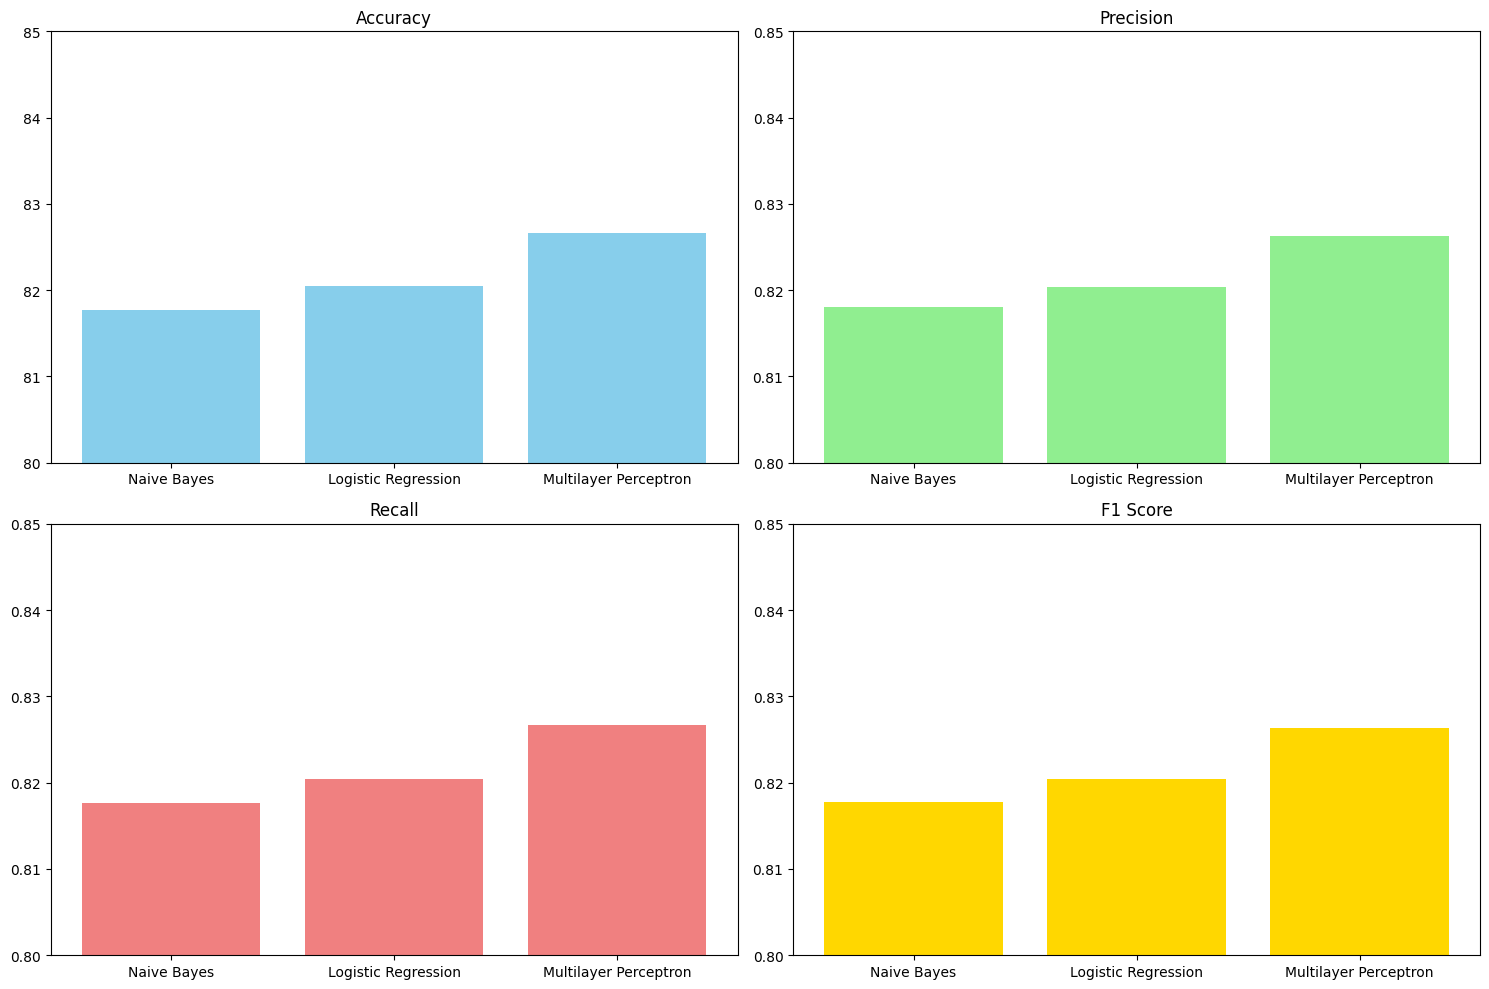

In [36]:
models = ["Naive Bayes", "Logistic Regression", "Multilayer Perceptron"]
# Create a 2x2 grid for the plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot Accuracy
axs[0, 0].bar(models, accuracies, color='skyblue')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylim([80, 85])

# Plot Precision
axs[0, 1].bar(models, precisions, color='lightgreen')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylim([0.8, 0.85])

# Plot Recall
axs[1, 0].bar(models, recalls, color='lightcoral')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylim([0.8, 0.85])

# Plot F1 Score
axs[1, 1].bar(models, f1s, color='gold')
axs[1, 1].set_title('F1 Score')
axs[1, 1].set_ylim([0.8, 0.85])

plt.tight_layout()
plt.show()

# Overall comparison


In [37]:
# Prepare the predictions for each model
model_preds = {
    "Naive Bayes": nb_preds,
    "Logistic Regression": lr_preds,
    "Multilayer Perceptron": mlp_preds,

}

# Calculate results for each model and store them
model_results = {}
for model_name, preds in model_preds.items():
    model_results[model_name] = calculate_results(y_true=y_test, y_pred=preds)


model_results["Bert"] = {
    "accuracy": report["accuracy"]*100,
    "precision": report["weighted avg"]["precision"],
    "recall": report["weighted avg"]["recall"],
    "f1": report["weighted avg"]["f1-score"]
}

# Print the formatted metrics for each model
accuracies,precisions,recalls,f1s = [],[],[],[]
for model_name, results in model_results.items():
    print(f"{model_name}:")
    print(f"Accuracy: {results['accuracy']:.2f}%")
    accuracies.append(results['accuracy'])
    print(f"Precision: {results['precision']:.3f}")
    precisions.append(results['precision'])
    print(f"Recall: {results['recall']:.3f}")
    recalls.append(results['recall'])
    print(f"F1 Score: {results['f1']:.3f}")
    f1s.append(results['f1'])
    print("----------------------------")

Naive Bayes:
Accuracy: 81.77%
Precision: 0.818
Recall: 0.818
F1 Score: 0.818
----------------------------
Logistic Regression:
Accuracy: 82.05%
Precision: 0.820
Recall: 0.820
F1 Score: 0.820
----------------------------
Multilayer Perceptron:
Accuracy: 82.67%
Precision: 0.826
Recall: 0.827
F1 Score: 0.826
----------------------------
Bert:
Accuracy: 92.85%
Precision: 0.929
Recall: 0.928
F1 Score: 0.928
----------------------------


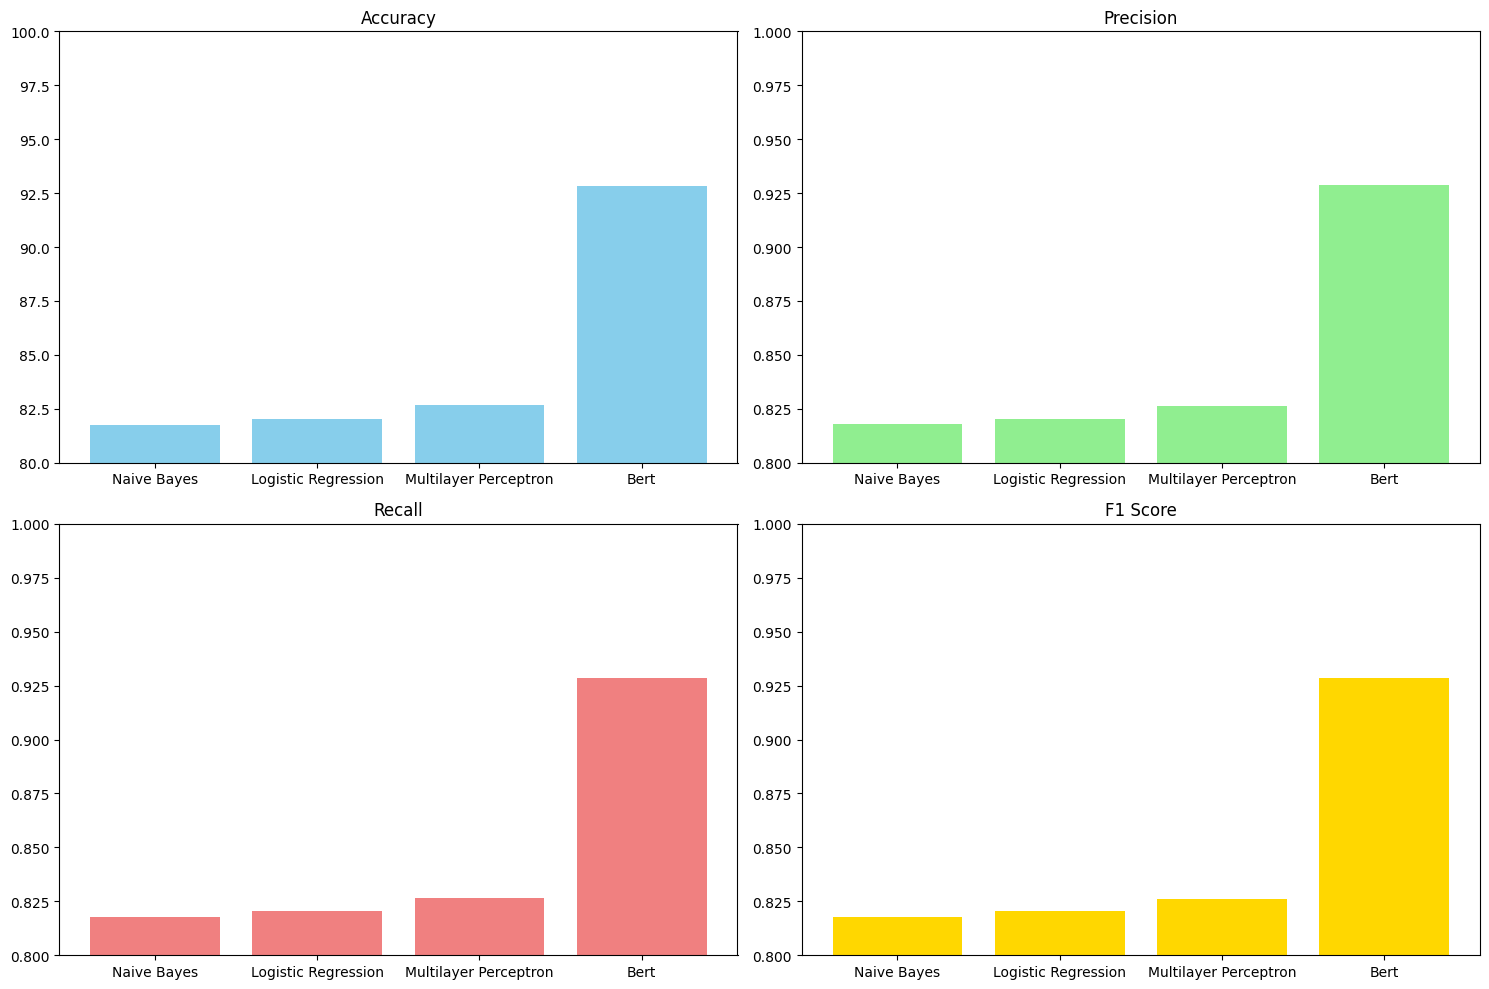

In [38]:
models = ["Naive Bayes", "Logistic Regression", "Multilayer Perceptron", "Bert"]
# Create a 2x2 grid for the plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot Accuracy
axs[0, 0].bar(models, accuracies, color='skyblue')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylim([80, 100])

# Plot Precision
axs[0, 1].bar(models, precisions, color='lightgreen')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylim([0.8, 1.0])

# Plot Recall
axs[1, 0].bar(models, recalls, color='lightcoral')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylim([0.8, 1.0])

# Plot F1 Score
axs[1, 1].bar(models, f1s, color='gold')
axs[1, 1].set_title('F1 Score')
axs[1, 1].set_ylim([0.8, 1.0])

plt.tight_layout()
plt.show()